# Assignment 4

The objective of this assignment is to introduce you to federated learning, with a particular focus on the challenges posed by data heterogeneity. Specifically, you will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.

You have been provided with a manual that includes detailed descriptions of each task. Follow the instructions in the manual carefully, and add your answers and implementations directly in this notebook.

Note: In this assignment, we concentrate on one common type of statistical heterogeneity: label skew. While feature skew is another significant aspect of heterogeneity, it will not be the focus of this assignment.

In [1]:
import os
import random
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset


In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.80MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.34MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [4]:
def partition_data_equal(train_data, train_targets, test_data, test_targets, num_clients, batch_size=32):
    num_samples = len(train_data)
    indices = np.arange(num_samples)
    # Shuffle indices deterministically
    np.random.seed(seed)
    np.random.shuffle(indices)
    split_sizes = [num_samples // num_clients] * num_clients
    for i in range(num_samples % num_clients):
        split_sizes[i] += 1
    client_indices = np.split(indices, np.cumsum(split_sizes)[:-1])

    federated_train_loaders = []
    for client_idx in client_indices:
        client_train_data = torch.tensor(train_data[client_idx], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_idx], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

    # Partition test data similarly
    num_test_samples = len(test_data)
    test_indices = np.arange(num_test_samples)
    np.random.seed(seed)
    np.random.shuffle(test_indices)
    test_split_sizes = [num_test_samples // num_clients] * num_clients
    for i in range(num_test_samples % num_clients):
        test_split_sizes[i] += 1
    client_test_indices = np.split(test_indices, np.cumsum(test_split_sizes)[:-1])

    federated_test_loaders = []
    for client_idx in client_test_indices:
        client_test_data = torch.tensor(test_data[client_idx], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_idx], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create centralized loaders
    centralized_data = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)
    centralized_targets = torch.tensor(train_targets, dtype=torch.long)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 1: Centralized Vs Federated Scenario

In this task, you will analyze the theoretical equivalence between FedSGD and a centralized training scenario. The code for both implementations has been provided. To minimize differences caused by floating-point precision, a batch size of 1 is used, along with full-batch gradient descent. You may change the device to cpu if you wish, as gpu will not be utilized for batch size of 1.

Since we are working with batch size 1 and full-batch gradient descent, accuracy is not the focus here. Instead, you will monitor gradient divergence by tracking the sum or magnitude of the gradients at each round and observe how they evolve in both settings.

Theoretically, FedSGD and centralized training should yield equivalent results. However, in this task, you may observe discrepancies. Your objective is to understand the code and identify the error that causes this divergence. You may want to review why FedSGD and full-batch centralized gradient descent are theoretically equivalent by revisiting the gradient descent steps on the global objective, as covered in class. Finally, assess whether the code aligns with these theoretical steps. If you believe they should not be equivalent, provide a reasoned justification.

# Equally distributing the data amoung all clients

In [6]:
num_clients = 5
dirichlet_alpha = 0.8
batch_size = 1





In [ ]:
# Use the modified partition_data_equal function
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data_equal(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, batch_size
)

In [7]:
def fedsgd_training(global_model, train_loaders, num_clients, rounds, lr):
    round_avg_updates = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)
    print(f"Using device: {device}")

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    total_data_count = 0
    for count in client_data_counts:
        total_data_count += count

    for round_num in range(rounds):
        client_updates = []
        print(f"Round {round_num + 1}/{rounds}")

        for client_id in range(num_clients):
            overall_update = local_train(global_model, train_loaders[client_id], lr)
            client_update_device = {name: update.to(device) for name, update in overall_update.items()}
            client_updates.append(client_update_device)

            client_update_sum = 0
            for update in client_update_device.values():
                client_update_sum += update.abs().sum().item()
            print(f"Client {client_id + 1} Update Sum at Round {round_num + 1}: {client_update_sum}")

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_updates[client_id][name]
            avg_update[name] = grad_sum

        round_avg_updates.append(avg_update)

        avg_update_sum = 0
        for update in avg_update.values():
            avg_update_sum += update.abs().sum().item()
        print(f"Averaged Update Sum at Round {round_num + 1}: {avg_update_sum}")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

    return round_avg_updates



def local_train(model, train_loader, lr):
    local_model = SimpleCNN()
    local_model.load_state_dict(model.state_dict())
    local_model.train()

    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    local_model.to(device)

    initial_weights = {name: param.clone() for name, param in local_model.named_parameters()}

    for epoch in range(1):
        print(f"Epoch {epoch + 1}/{1} for local client")
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        # Loop over batches
        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = local_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

    overall_update = {name: initial_weights[name] - param for name, param in local_model.named_parameters()}

    return overall_update


In [8]:
def centralized_training_updates(global_model, train_loader, epochs, lr):
    centralized_model = SimpleCNN()
    centralized_model.load_state_dict(global_model.state_dict())
    centralized_model.train()

    optimizer = optim.SGD(centralized_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    centralized_model.to(device)

    epoch_updates = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_initial_weights = {name: param.clone() for name, param in centralized_model.named_parameters()}
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = centralized_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()

            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

        epoch_update = {name: param - epoch_initial_weights[name]  for name, param in centralized_model.named_parameters()}
        epoch_updates.append(epoch_update)

        epoch_update_sum = 0
        for update in epoch_update.values():
            epoch_update_sum += update.abs().sum().item()

        print(f"Epoch {epoch + 1} Update Sum: {epoch_update_sum}")

    global_model.load_state_dict(centralized_model.state_dict())

    return epoch_updates


In [9]:
# Initialize model and parameters
rounds = 4
lr = 1e-4
initial_model = SimpleCNN()

In [21]:
# Centralized Training
global_model_centralized = SimpleCNN()
global_model_centralized.load_state_dict(initial_model.state_dict())
centralized_updates = centralized_training_updates(global_model_centralized, train_centralized_loader, epochs=rounds, lr=lr)

Using device: cuda
Epoch 1/4


Training Batches (Epoch 1): 100%|██████████| 48000/48000 [03:37<00:00, 220.55it/s, loss=2.27]


Epoch 1 Update Sum: 274.6468212455511
Epoch 2/4


Training Batches (Epoch 2): 100%|██████████| 48000/48000 [03:40<00:00, 218.07it/s, loss=2.22]


Epoch 2 Update Sum: 374.66806879639626
Epoch 3/4


Training Batches (Epoch 3): 100%|██████████| 48000/48000 [03:36<00:00, 221.66it/s, loss=1.24]


Epoch 3 Update Sum: 4553.069828748703
Epoch 4/4


Training Batches (Epoch 4): 100%|██████████| 48000/48000 [03:35<00:00, 222.81it/s, loss=1.23e+3]


Epoch 4 Update Sum: 265180.92505836487


In [20]:
# Fedsgd
global_model_fedsgd = SimpleCNN()
global_model_fedsgd.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates = fedsgd_training(global_model_fedsgd, federated_train_loaders, num_clients, rounds=rounds, lr=lr)

Using device: cuda
Round 1/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 216.46it/s, loss=2.29]


Client 1 Update Sum at Round 1: 55.93630897626281
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 218.15it/s, loss=2.32]


Client 2 Update Sum at Round 1: 54.05830713361502
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:45<00:00, 212.92it/s, loss=2.31]


Client 3 Update Sum at Round 1: 54.62515549361706
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 214.72it/s, loss=2.27]


Client 4 Update Sum at Round 1: 57.53683461621404
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 214.27it/s, loss=2.36]


Client 5 Update Sum at Round 1: 55.120809299871325
Averaged Update Sum at Round 1: 274.6468363106251
Round 2/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 216.86it/s, loss=2.26]


Client 1 Update Sum at Round 2: 74.20894050225616
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 217.99it/s, loss=2.29]


Client 2 Update Sum at Round 2: 75.8680550083518
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:45<00:00, 212.91it/s, loss=2.14]


Client 3 Update Sum at Round 2: 75.76335598528385
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 217.70it/s, loss=2.18]


Client 4 Update Sum at Round 2: 75.15732084959745
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 217.61it/s, loss=2.05]


Client 5 Update Sum at Round 2: 75.85951329022646
Averaged Update Sum at Round 2: 374.6673586368561
Round 3/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 217.22it/s, loss=1.04]


Client 1 Update Sum at Round 3: 913.4495292305946
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 216.91it/s, loss=1.36]


Client 2 Update Sum at Round 3: 890.4053272604942
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 214.87it/s, loss=2.1]


Client 3 Update Sum at Round 3: 910.7995156049728
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 216.69it/s, loss=2.61]


Client 4 Update Sum at Round 3: 950.3755027651787
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 214.70it/s, loss=2.94]


Client 5 Update Sum at Round 3: 892.425296664238
Averaged Update Sum at Round 3: 4553.077459812164
Round 4/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 216.99it/s, loss=590]


Client 1 Update Sum at Round 4: 52652.77111697197
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:45<00:00, 212.65it/s, loss=368]


Client 2 Update Sum at Round 4: 53245.03164875507
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:44<00:00, 213.86it/s, loss=251]


Client 3 Update Sum at Round 4: 53407.008563280106
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:43<00:00, 218.46it/s, loss=225]


Client 4 Update Sum at Round 4: 52415.015511512756
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [00:42<00:00, 224.20it/s, loss=0]


Client 5 Update Sum at Round 4: 53461.3667383194
Averaged Update Sum at Round 4: 265179.38376903534


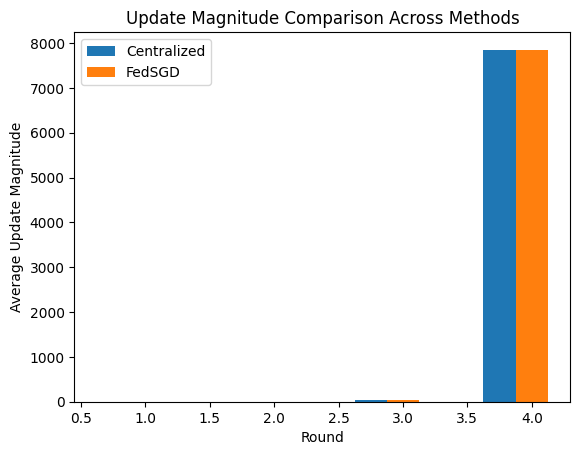

Success! The gradients are approximately the same.


In [23]:
# Calculate update magnitudes for each round
centralized_magnitudes = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates]
fedsgd_magnitudes = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes, fedsgd_magnitudes))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")

In [24]:
print(centralized_magnitudes)
print(fedsgd_magnitudes)


[1.3953942004591227, 3.1539922058582306, 33.13291049003601, 7850.4540004730225]
[1.395393967628479, 3.1539866775274277, 33.13290745019913, 7850.460466384888]


# Original code

In [10]:
# Partition data and create loaders
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size
)



In [11]:
# Initialize model and parameters
rounds = 4
lr = 1e-4
initial_model = SimpleCNN()

# Centralized Training
global_model_centralized_original = SimpleCNN()
global_model_centralized_original.load_state_dict(initial_model.state_dict())
centralized_updates_original = centralized_training_updates(global_model_centralized_original, train_centralized_loader, epochs=rounds, lr=lr)




Using device: cpu
Epoch 1/4


Training Batches (Epoch 1): 100%|██████████| 48000/48000 [06:41<00:00, 119.43it/s, loss=2.3]


Epoch 1 Update Sum: 336.184920232743
Epoch 2/4


Training Batches (Epoch 2): 100%|██████████| 48000/48000 [06:28<00:00, 123.63it/s, loss=2.29]


Epoch 2 Update Sum: 460.450255215168
Epoch 3/4


Training Batches (Epoch 3): 100%|██████████| 48000/48000 [06:27<00:00, 124.02it/s, loss=4.37]


Epoch 3 Update Sum: 16963.090428352356
Epoch 4/4


Training Batches (Epoch 4): 100%|██████████| 48000/48000 [06:23<00:00, 125.25it/s, loss=1.87]


Epoch 4 Update Sum: 7113.687885284424


In [12]:
# Fedsgd
global_model_fedsgd_original = SimpleCNN()
global_model_fedsgd_original.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates_original = fedsgd_training(global_model_fedsgd_original, federated_train_loaders, num_clients, rounds=rounds, lr=lr)



Using device: cpu
Round 1/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 11286/11286 [01:31<00:00, 123.77it/s, loss=2.3]


Client 1 Update Sum at Round 1: 159.3787695541978
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 13796/13796 [01:50<00:00, 124.77it/s, loss=2.28]


Client 2 Update Sum at Round 1: 313.60194873809814
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9345/9345 [01:16<00:00, 122.80it/s, loss=2.29]


Client 3 Update Sum at Round 1: 184.76244822517037
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5792/5792 [00:46<00:00, 123.92it/s, loss=2.27]


Client 4 Update Sum at Round 1: 145.85181955620646
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7781/7781 [01:01<00:00, 127.38it/s, loss=2.3]


Client 5 Update Sum at Round 1: 175.1164625454694
Averaged Update Sum at Round 1: 336.1849547661841
Round 2/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 11286/11286 [01:29<00:00, 125.73it/s, loss=2.29]


Client 1 Update Sum at Round 2: 197.48734186589718
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 13796/13796 [01:52<00:00, 122.53it/s, loss=2.25]


Client 2 Update Sum at Round 2: 341.245932251215
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9345/9345 [01:14<00:00, 125.85it/s, loss=2.28]


Client 3 Update Sum at Round 2: 194.24541832506657
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5792/5792 [00:45<00:00, 126.34it/s, loss=2.23]


Client 4 Update Sum at Round 2: 156.89571165293455
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7781/7781 [01:02<00:00, 124.36it/s, loss=2.29]


Client 5 Update Sum at Round 2: 204.8738894239068
Averaged Update Sum at Round 2: 460.45009449124336
Round 3/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 11286/11286 [01:29<00:00, 126.43it/s, loss=3.93]


Client 1 Update Sum at Round 3: 4137.533456325531
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 13796/13796 [01:50<00:00, 124.63it/s, loss=2.93]


Client 2 Update Sum at Round 3: 5298.2129778862
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9345/9345 [01:16<00:00, 122.84it/s, loss=3.75]


Client 3 Update Sum at Round 3: 3677.7929681539536
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5792/5792 [00:46<00:00, 124.90it/s, loss=2.1]


Client 4 Update Sum at Round 3: 2376.8136415481567
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7781/7781 [01:03<00:00, 122.76it/s, loss=4.37]


Client 5 Update Sum at Round 3: 2631.2267612218857
Averaged Update Sum at Round 3: 16963.178297042847
Round 4/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 11286/11286 [01:31<00:00, 123.97it/s, loss=1.86]


Client 1 Update Sum at Round 4: 2106.8480422496796
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 13796/13796 [01:53<00:00, 121.73it/s, loss=1.84]


Client 2 Update Sum at Round 4: 1329.1633851528168
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9345/9345 [01:17<00:00, 121.17it/s, loss=1.86]


Client 3 Update Sum at Round 4: 1289.7158155441284
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5792/5792 [00:48<00:00, 119.35it/s, loss=1.85]


Client 4 Update Sum at Round 4: 543.6021106243134
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7781/7781 [01:04<00:00, 121.57it/s, loss=1.87]


Client 5 Update Sum at Round 4: 1898.6742228269577
Averaged Update Sum at Round 4: 7113.467388153076


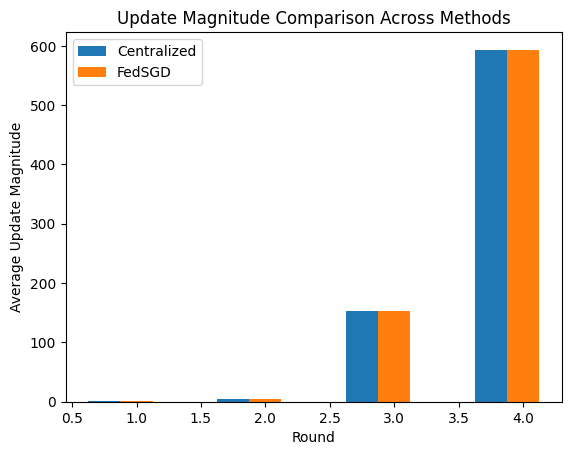

Keep trying


In [13]:
# Calculate update magnitudes for each round
centralized_magnitudes_original = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates_original]
fedsgd_magnitudes_original = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates_original]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes_original, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes_original, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes_original, fedsgd_magnitudes_original))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")

Assigning Weights proportional to the Data of a Client(Weighted Aggregation)




In [14]:
def fedsgd_training_weights(global_model, train_loaders, num_clients, rounds, lr):
    round_avg_updates = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)
    print(f"Using device: {device}")

    # Compute data counts and proportions
    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    total_data_count = sum(client_data_counts)
    client_weights = [count / total_data_count for count in client_data_counts]

    print("Client Data Counts:", client_data_counts)
    print("Client Weights:", client_weights)

    for round_num in range(rounds):
        client_updates = []
        print(f"Round {round_num + 1}/{rounds}")

        for client_id in range(num_clients):
            overall_update = local_train(global_model, train_loaders[client_id], lr)
            client_update_device = {name: update.to(device) for name, update in overall_update.items()}
            client_updates.append(client_update_device)

            client_update_sum = sum(update.abs().sum().item() for update in client_update_device.values())
            print(f"Client {client_id + 1} Update Sum at Round {round_num + 1}: {client_update_sum}")

        # Aggregate client updates with weights
        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_weights[client_id] * client_updates[client_id][name]
            avg_update[name] = grad_sum

        round_avg_updates.append(avg_update)

        avg_update_sum = sum(update.abs().sum().item() for update in avg_update.values())
        print(f"Averaged Update Sum at Round {round_num + 1}: {avg_update_sum}")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

    return round_avg_updates


In [15]:
# FedSGD with Weighted Aggregation
global_model_fedsgd_weights = SimpleCNN()
global_model_fedsgd_weights.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates_weights = fedsgd_training_weights(global_model_fedsgd_weights, federated_train_loaders, num_clients, rounds=rounds, lr=lr)


Using device: cpu
Client Data Counts: [11286, 13796, 9345, 5792, 7781]
Client Weights: [0.235125, 0.28741666666666665, 0.1946875, 0.12066666666666667, 0.16210416666666666]
Round 1/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 11286/11286 [01:30<00:00, 125.00it/s, loss=2.3]


Client 1 Update Sum at Round 1: 159.3787695541978
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 13796/13796 [01:51<00:00, 124.08it/s, loss=2.28]


Client 2 Update Sum at Round 1: 313.60194873809814
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9345/9345 [01:15<00:00, 123.02it/s, loss=2.29]


Client 3 Update Sum at Round 1: 184.76244822517037
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5792/5792 [00:47<00:00, 122.91it/s, loss=2.27]


Client 4 Update Sum at Round 1: 145.85181955620646
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7781/7781 [01:02<00:00, 124.68it/s, loss=2.3]


Client 5 Update Sum at Round 1: 175.1164625454694
Averaged Update Sum at Round 1: 84.01092879381031
Round 2/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 11286/11286 [01:30<00:00, 124.47it/s, loss=2.21]


Client 1 Update Sum at Round 2: 155.9523180089891
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 13796/13796 [01:51<00:00, 123.58it/s, loss=2.19]


Client 2 Update Sum at Round 2: 258.0512755215168
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9345/9345 [01:15<00:00, 123.07it/s, loss=2.2]


Client 3 Update Sum at Round 2: 181.0507306419313
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5792/5792 [00:47<00:00, 122.72it/s, loss=2.18]


Client 4 Update Sum at Round 2: 146.3601320311427
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7781/7781 [01:07<00:00, 115.31it/s, loss=2.21]


Client 5 Update Sum at Round 2: 169.5396641306579
Averaged Update Sum at Round 2: 66.57688134908676
Round 3/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 11286/11286 [01:34<00:00, 119.26it/s, loss=2.14]


Client 1 Update Sum at Round 3: 229.8474940955639
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 13796/13796 [02:00<00:00, 114.67it/s, loss=2.1]


Client 2 Update Sum at Round 3: 377.29143810272217
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9345/9345 [01:18<00:00, 118.56it/s, loss=2.11]


Client 3 Update Sum at Round 3: 272.81067030876875
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5792/5792 [00:48<00:00, 118.87it/s, loss=2.07]


Client 4 Update Sum at Round 3: 226.95482981204987
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7781/7781 [01:05<00:00, 118.27it/s, loss=2.12]


Client 5 Update Sum at Round 3: 257.64883141219616
Averaged Update Sum at Round 3: 87.80674229934812
Round 4/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 11286/11286 [01:35<00:00, 118.49it/s, loss=2.11]


Client 1 Update Sum at Round 4: 382.39030645787716
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 13796/13796 [01:58<00:00, 116.84it/s, loss=2.03]


Client 2 Update Sum at Round 4: 600.6241924464703
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9345/9345 [01:19<00:00, 116.86it/s, loss=2.06]


Client 3 Update Sum at Round 4: 455.2884258031845
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5792/5792 [00:48<00:00, 118.53it/s, loss=1.94]


Client 4 Update Sum at Round 4: 375.714820638299
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7781/7781 [01:06<00:00, 116.62it/s, loss=2.07]


Client 5 Update Sum at Round 4: 423.84432423114777
Averaged Update Sum at Round 4: 143.29100538045168


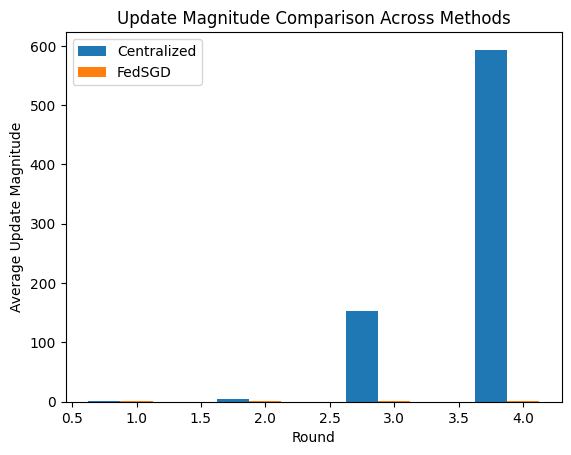

Keep trying


In [16]:
# Calculate update magnitudes for each round
centralized_magnitudes_original = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates_original]
fedsgd_magnitudes_weights = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates_weights]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes_original, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes_weights, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes_original, fedsgd_magnitudes_weights))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")

In [18]:
# sum([0.235125, 0.28741666666666665, 0.1946875, 0.12066666666666667, 0.16210416666666666])
print(centralized_magnitudes_original)
print(fedsgd_magnitudes_weights)

[1.682474821805954, 3.831089347600937, 152.47307932376862, 593.3741135597229]
[0.4722092517185956, 0.4682182865217328, 0.6660248432308435, 1.1522399317473173]


Uniform data distribution and weighted aggregation


In [19]:
# Use the modified partition_data_equal function
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data_equal(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, batch_size
)

In [20]:
# Centralized Training
global_model_centralized_uniform_weighted = SimpleCNN()
global_model_centralized_uniform_weighted.load_state_dict(initial_model.state_dict())
centralized_updates_uniform_weighted = centralized_training_updates(global_model_centralized_uniform_weighted, train_centralized_loader, epochs=rounds, lr=lr)

Using device: cpu
Epoch 1/4


Training Batches (Epoch 1): 100%|██████████| 48000/48000 [06:49<00:00, 117.26it/s, loss=2.2]


Epoch 1 Update Sum: 336.1849522739649
Epoch 2/4


Training Batches (Epoch 2): 100%|██████████| 48000/48000 [06:48<00:00, 117.61it/s, loss=2.32]


Epoch 2 Update Sum: 460.44950807094574
Epoch 3/4


Training Batches (Epoch 3): 100%|██████████| 48000/48000 [06:45<00:00, 118.27it/s, loss=0.0311]


Epoch 3 Update Sum: 16963.123607635498
Epoch 4/4


Training Batches (Epoch 4): 100%|██████████| 48000/48000 [06:51<00:00, 116.60it/s, loss=122]


Epoch 4 Update Sum: 7113.695724487305


In [21]:
# FedSGD with Weighted Aggregation
global_model_fedsgd_weights_uniform = SimpleCNN()
global_model_fedsgd_weights_uniform.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates_weights = fedsgd_training_weights(global_model_fedsgd_weights_uniform, federated_train_loaders, num_clients, rounds=rounds, lr=lr)


Using device: cpu
Client Data Counts: [9600, 9600, 9600, 9600, 9600]
Client Weights: [0.2, 0.2, 0.2, 0.2, 0.2]
Round 1/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:20<00:00, 119.29it/s, loss=2.27]


Client 1 Update Sum at Round 1: 68.31279277708381
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:21<00:00, 118.39it/s, loss=2.32]


Client 2 Update Sum at Round 1: 65.995908876881
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:21<00:00, 118.07it/s, loss=2.33]


Client 3 Update Sum at Round 1: 66.53967094793916
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:27<00:00, 109.35it/s, loss=2.23]


Client 4 Update Sum at Round 1: 70.80306912213564
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:26<00:00, 111.00it/s, loss=2.4]


Client 5 Update Sum at Round 1: 67.00418430566788
Averaged Update Sum at Round 1: 67.2369871372357
Round 2/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:23<00:00, 114.52it/s, loss=2.24]


Client 1 Update Sum at Round 2: 59.274999387562275
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:23<00:00, 114.35it/s, loss=2.31]


Client 2 Update Sum at Round 2: 58.9545973688364
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:23<00:00, 114.39it/s, loss=2.26]


Client 3 Update Sum at Round 2: 59.032590225338936
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:22<00:00, 116.38it/s, loss=2.24]


Client 4 Update Sum at Round 2: 61.01756416633725
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:23<00:00, 114.91it/s, loss=2.25]


Client 5 Update Sum at Round 2: 59.471461502835155
Averaged Update Sum at Round 2: 58.96081758476794
Round 3/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:22<00:00, 116.79it/s, loss=2.18]


Client 1 Update Sum at Round 3: 75.24645578861237
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:20<00:00, 118.82it/s, loss=2.27]


Client 2 Update Sum at Round 3: 75.71369833499193
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:21<00:00, 117.96it/s, loss=2.2]


Client 3 Update Sum at Round 3: 76.05140332505107
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:21<00:00, 117.99it/s, loss=2.23]


Client 4 Update Sum at Round 3: 77.4842296205461
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:21<00:00, 118.02it/s, loss=2.14]


Client 5 Update Sum at Round 3: 76.28537832573056
Averaged Update Sum at Round 3: 75.36666199192405
Round 4/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:21<00:00, 118.29it/s, loss=2.06]


Client 1 Update Sum at Round 4: 112.14379418641329
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:21<00:00, 117.85it/s, loss=2.18]


Client 2 Update Sum at Round 4: 114.92345014959574
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:22<00:00, 115.68it/s, loss=2.12]


Client 3 Update Sum at Round 4: 115.93830855190754
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:21<00:00, 117.84it/s, loss=2.2]


Client 4 Update Sum at Round 4: 115.7549758926034
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9600/9600 [01:24<00:00, 113.05it/s, loss=1.93]


Client 5 Update Sum at Round 4: 116.04892559349537
Averaged Update Sum at Round 4: 113.88937835395336


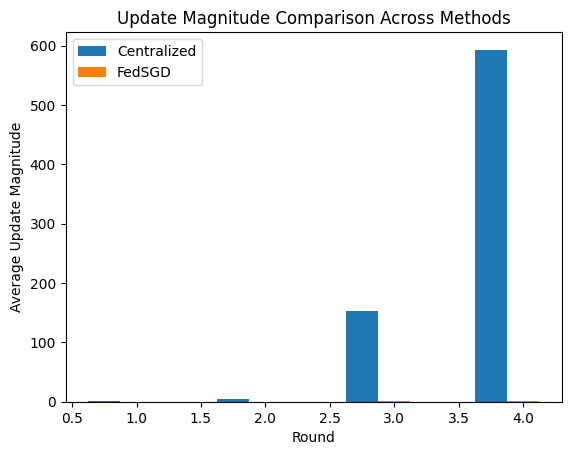

Keep trying


In [22]:
# Calculate update magnitudes for each round
centralized_magnitudes_uniform_weights = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates_uniform_weighted]
fedsgd_magnitudes_uniform_weighted = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates_weights]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes_uniform_weights, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes_uniform_weighted, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes_uniform_weights, fedsgd_magnitudes_uniform_weighted))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")

In [24]:
print(centralized_magnitudes_uniform_weights)
print(fedsgd_magnitudes_uniform_weighted)

[1.6824751272797585, 3.831090658903122, 152.4730987548828, 593.3658180236816]
[0.33649478713050485, 0.3738701492547989, 0.545261250808835, 0.9039998911321163]


# Task 2: FedAvg

Implement the fedavg_training function to perform Federated Averaging (FedAvg) over multiple communication rounds. Each round, collect updates from clients by training locally on their data and average these updates to form a new global model.

Additionally, implement the local_train function to handle client-side training. You are not restricted to using full-batch gradient descent; feel free to use mini-batch gradient descent instead. Make sure your implementation aligns with the provided code to plot the accuracies, as you should not modify that code.

In [ ]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



In [ ]:
def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    # To Do
    return round_avg_updates, round_accuracies



def local_train(model, train_loader, epochs, lr):
    overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    #To Do
    return overall_update


In the following code you may change the learning rate or the batch size

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies

accuracies_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies = run_fedavg(alpha)
    accuracies_per_alpha.append(round_accuracies)


In [ ]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()

# Task 3: Scaffold

In this task, you will implement the SCAFFOLD algorithm, which addresses client heterogeneity through variance reduction. We will evaluate the implementation in a 0.1 Dirichlet heterogeneous setting, and accuracy plotting code is provided.

The implementation of SCAFFOLD is similar to FedAvg, with only a few additional steps at both the server and client side. For reference, you may consult the SCAFFOLD paper to understand these adjustments in detail.

In [ ]:
def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr):
    overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    new_c_local = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    # To Do
    return overall_update, new_c_local

def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
    round_accuracies = []
    # To Do
    return round_accuracies

In [ ]:
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
mu = 0.001

# Run federated SCAFFOLD with 0.1 Dirichlet and plot accuracy per round
def run_scaffold():
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size)
    global_model_scaffold = SimpleCNN()
    round_accuracies = federated_scaffold(global_model_scaffold, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies

# Run SCAFFOLD and get accuracy per round
scaffold_accuracies = run_scaffold()

In [ ]:
plt.figure()
plt.plot(range(1, rounds + 1), scaffold_accuracies, marker='o', label='SCAFFOLD Alpha = 0.1')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('SCAFFOLD Accuracy per Round (Dirichlet Alpha = 0.1)')
plt.legend()
plt.show()

# Task 4: Gradient Harmonization

In this task, you will examine how heterogeneity influences the gradient updates sent by each client. Specifically, you will analyze and quantify gradient conflicts at varying levels of heterogeneity.

First, implement the FedAvg code (You can reuse your task 2 implementation) and integrate the provided conflict-counting function at the end of each round to measure the number of conflicts in different heterogeneous settings.

Next, implement the Gradient Harmonization algorithm to harmonize conflicting gradients.

Finally, evaluate the performance of the harmonized gradients under a 0.1 Dirichlet scenario, and compare the number of conflicts before and after harmonization.

In [ ]:
import builtins
sum = builtins.sum

def cosine_similarity(vec1, vec2):
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

def gradient_conflict_counter(client_updates):
    total_conflicts = 0  # Variable to store the total conflicts across all layers
    num_clients = len(client_updates)

    # Iterate over each layer (key) in the client updates
    for layer_name in client_updates[0].keys():
        # Collect vectors for this layer across all clients
        layer_vectors = [client_update[layer_name].view(-1).cpu() for client_update in client_updates]

        # Check pairwise cosine similarity for this layer and count conflicts
        for i in range(num_clients):
            for j in range(i + 1, num_clients):
                sim = cosine_similarity(layer_vectors[i], layer_vectors[j])
                if sim < 0:
                    total_conflicts += 1

    print(f"Total gradient conflicts detected: {total_conflicts}")
    return total_conflicts

def Federated_gradient_conflict(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    conflict_counts = []
    # To Do
    return round_avg_updates, round_accuracies, conflict_counts

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedconflict(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies,conflict_counts = Federated_gradient_conflict(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies, conflict_counts

accuracies_per_alpha = []
conflicts_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies, conflict_counts = run_fedconflict(alpha)
    accuracies_per_alpha.append(round_accuracies)
    conflicts_per_alpha.append(conflict_counts)



In [ ]:
plt.figure(figsize=(10, 6))

for i, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), conflicts_per_alpha[i], marker='o', label=f'Alpha = {alpha}')

plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
def gradient_harmonization(client_updates):
    # To Do
    return client_updates

def Federated_gradient_harmonization(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_accuracies = []  # List to store total accuracy after each round
    pre_harmonization_conflicts = []  # List to store conflicts before harmonization
    post_harmonization_conflicts = []  # List to store conflicts after harmonization
    # To Do
    return round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts


In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
alpha = 0.1

# Run federated gradient harmonization
train_loaders, test_loaders, _, _ = partition_data(
    train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size
)
global_model_fedavg = SimpleCNN()
round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts = Federated_gradient_harmonization(
    global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders
)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, rounds + 1), pre_harmonization_conflicts, marker='o', linestyle='-', label='Conflicts Before Harmonization')
plt.plot(range(1, rounds + 1), post_harmonization_conflicts, marker='x', linestyle='--', label='Conflicts After Harmonization')
plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds (Alpha = 0.1)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(range(1, rounds + 1), round_accuracies, marker='s', color='b')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Across Rounds (Alpha = 0.1)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# Task 5: FedSam

In this task, you will explore Sharpness-Aware Minimization (SAM) in a federated learning setting by implementing the FedSAM algorithm. As with previous tasks, evaluate its performance in a 0.1 Dirichlet heterogeneous scenario.

In [ ]:
def apply_sam_perturbation(local_model, criterion, x_train, y_train, rho):
    # To Do
    pass

def local_train_sam(model, train_loader, epochs, lr, rho=0.0001):
    overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    # To do
    return overall_update

def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
    round_accuracies = []
    # To Do
    return round_accuracies

In [ ]:
# Run the FedSAM experiment
num_clients = 5
rounds = 3
epochs = 20
lr = 0.001

def run_fedsam():
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies

# Run FedSAM and get accuracy per round
sam_accuracies = run_fedsam()



In [ ]:
# Plotting accuracy per round for FedSAM with Dirichlet alpha 0.1
plt.figure()
plt.plot(range(1, rounds + 1), sam_accuracies, marker='o', label='FedSAM Alpha = 0.1')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('FedSAM Accuracy per Round (Dirichlet Alpha = 0.1)')
plt.legend()
plt.show()